
# Forward Simulation for Straight Ray Tomography in 2D

Here we module *simpeg.seismic.straight_ray_tomography* to predict arrival
time data for a synthetic velocity/slowness model. In this tutorial, we focus on the following:

    - How to define the survey
    - How to define the forward simulation
    - How to predict arrival time data


## Import Modules




In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh

from simpeg import maps
from simpeg.seismic import straight_ray_tomography as tomo
from simpeg.utils import model_builder

save_file = True

## Defining the Survey

Here, we define survey that will be used for the forward simulation. The survey
consists of a horizontal line of point receivers at Y = 100 m and a horizontal
line of point sources at Y = -100 m. The shot by each source is measured by
all receivers.




In [5]:
# Define the locations for the sources and receivers.
x = np.linspace(-100, 100, 11)
y_receivers = 100 * np.ones(len(x))
y_sources = -100 * np.ones(len(x))

receiver_locations = np.c_[x, y_receivers]
source_locations = np.c_[x, y_sources]

# Define the list of receivers used by each source
receiver_list = [tomo.Rx(receiver_locations)]

# Define an empty list to store sources objects. Define each source and
# provide its corresponding receivers list
source_list = []
for ii in range(0, len(y_sources)):
    source_list.append(
        tomo.Src(location=source_locations[ii, :], receiver_list=receiver_list)
    )

# Define they tomography survey
survey = tomo.Survey(source_list)

## Defining a Tensor Mesh

Here, we create the tensor mesh that will be used to predict arrival time
data.




In [9]:
dh = 10.0  # cell width
N = 21  # number of cells in X and Y direction
hx = [(dh, N)]
hy = [(dh, N)]
mesh = TensorMesh([hx, hy], "CC")
mesh

TensorMesh: 441 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     21       -105.00        105.00     10.00     10.00    1.00
   y     21       -105.00        105.00     10.00     10.00    1.00

<Axes: xlabel='x1', ylabel='x2'>

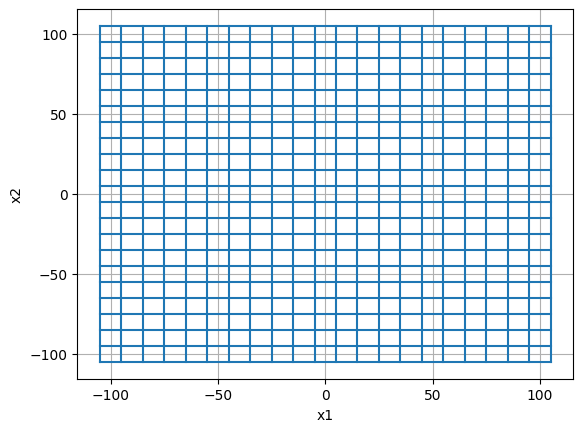

In [10]:
mesh.plot_grid()

## Model and Mapping on Tensor Mesh

Here, we create the velocity model that will be used to predict the data. Since
the physical parameter for straight ray tomography is slowness, we must define
a mapping which converts velocity values to slowness values. The model
consists of a lower velocity block within a higher velocity background.




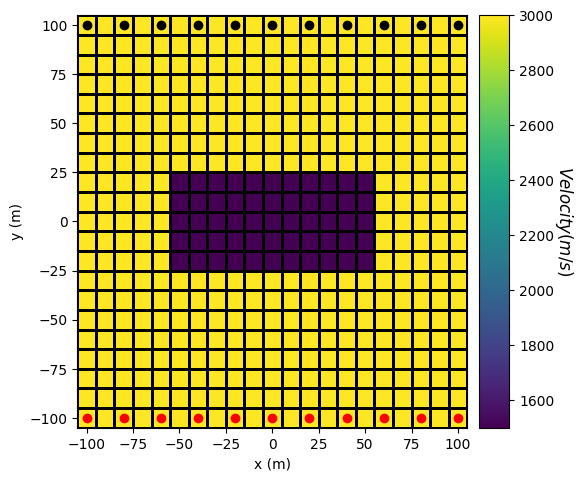

In [12]:
# Define velocity of each unit in m/s
background_velocity = 3000.0
block_velocity = 1500.0

# Define the model. Models in SimPEG are vector arrays.
model = background_velocity * np.ones(mesh.nC)

ind_block = model_builder.get_indices_block(np.r_[-50, 20], np.r_[50, -20], mesh.gridCC)
model[ind_block] = block_velocity

# Define a mapping from the model (velocity) to the slowness. If your model
# consists of slowness values, you can use *maps.IdentityMap*.
model_mapping = maps.ReciprocalMap()

# Plot Velocity Model
fig = plt.figure(figsize=(6, 5.5))

ax1 = fig.add_axes([0.15, 0.15, 0.65, 0.75])
mesh.plot_image(model, ax=ax1, grid=True, pcolor_opts={"cmap": "viridis"})
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.plot(x, y_sources, "ro")  # source locations
ax1.plot(x, y_receivers, "ko")  # receiver locations

ax2 = fig.add_axes([0.82, 0.15, 0.05, 0.75])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$Velocity (m/s)$", rotation=270, labelpad=15, size=12)

## Simulation: Arrival Time

Here we demonstrate how to predict arrival time data for the 2D straight
ray tomography problem using the 2D Integral formulation.




In [13]:
# Define the forward simulation. To do this we need the mesh, the survey and
# the mapping from the model to the slowness values on the mesh.
simulation = tomo.Simulation(mesh, survey=survey, slownessMap=model_mapping)

# Compute predicted data for some model
dpred = simulation.dpred(model)

In [14]:
dpred.shape

(121,)

## Plotting




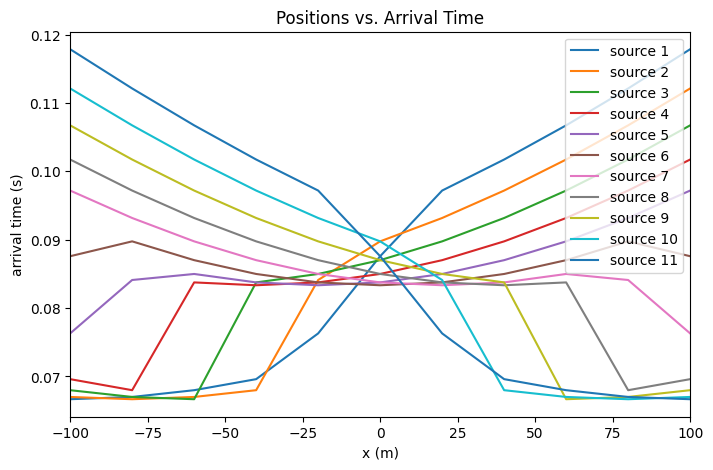

In [15]:
n_source = len(source_list)
n_receiver = len(x)
dpred_plotting = dpred.reshape(n_receiver, n_source)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
obs_string = []

for ii in range(0, n_source):
    ax.plot(x, dpred_plotting[:, ii])
    obs_string.append("source {}".format(ii + 1))

ax.set_xlim(np.min(x), np.max(x))
ax.set_xlabel("x (m)")
ax.set_ylabel("arrival time (s)")
ax.set_title("Positions vs. Arrival Time")
ax.legend(obs_string, loc="upper right")

## Optional: Exporting Results

Write the data and true model




In [16]:
!mkdir data

mkdir: data: File exists


In [19]:
if save_file:
    dir_path = './data/'

    noise = dpred * np.random.randn(len(dpred)) * 0.02

    data_array = np.c_[
        np.kron(x, np.ones(n_receiver)),
        np.kron(y_sources, np.ones(n_receiver)),
        np.kron(np.ones(n_source), x),
        np.kron(np.ones(n_source), y_receivers),
        dpred + noise,
    ]

    fname = dir_path + "tomography2D_data.obs"
    np.savetxt(fname, data_array, fmt="%.4e")

    output_model = model
    fname = dir_path + "true_model_2D.txt"
    np.savetxt(fname, output_model, fmt="%.4e")